# 11-14.프로젝트 : CIFAR-10 이미지 생성하기 (Optional)

## STEP 1. 작업환경 구성하기

In [1]:
# ! pip list | grep -E 'imageio|Pillow'

In [2]:
# ! pip install imageio
# ! pip install Pillow

In [3]:
# ! mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples2
# ! mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints2
# ! mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history2

In [4]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)
print("imageio", imageio.__version__)

tensorflow 2.6.0
imageio 2.9.0


## STEP 2. 데이터셋 구성하기

### 2-1. Data Set 가져오기

In [5]:
# Data Set 가져오기

cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()
train_x.shape

170508288/170498071 [==============================] - 7s 0us/step


(50000, 32, 32, 3)

In [6]:
# Data Set 픽셀 사이즈 확인

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


### 2-2. 학습에 사용할 train_x의 이미지를 -1, 1로 정규화

In [7]:
# 각 픽셀을 -1, 1로 정규화시켜서 사용할 예정이므로, 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눔

train_x = (train_x - 127.5) / 127.5  # 이미지를 [-1, 1]로 정규화합니다.
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


### 2-3. 로드한 학습 데이터를 시각화를 통해 확인

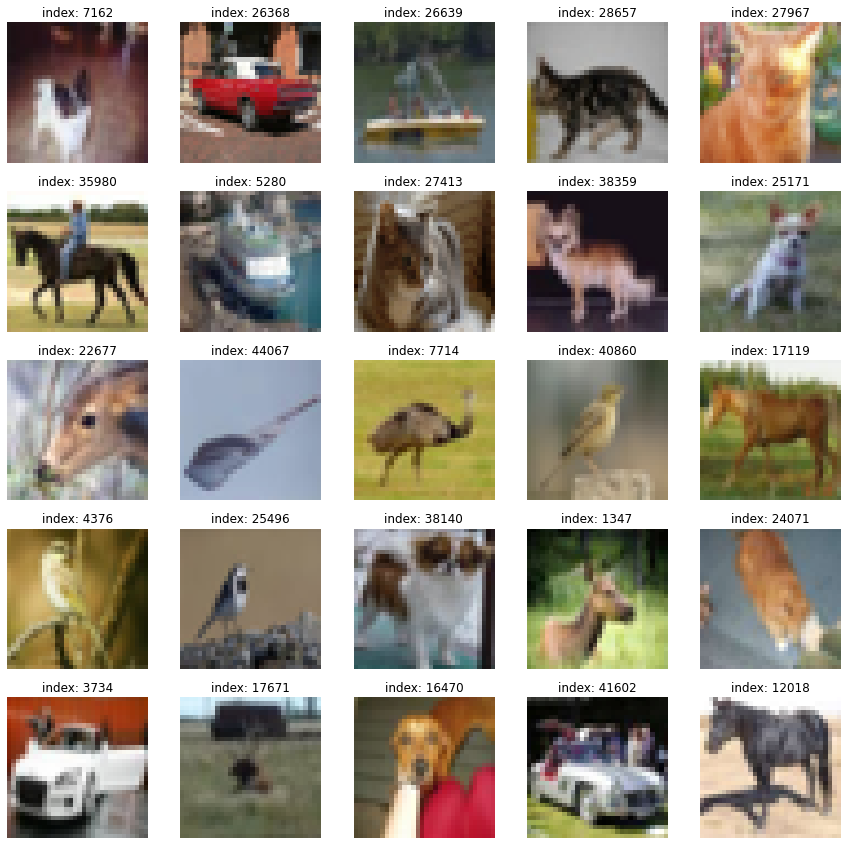

In [8]:
plt.figure(figsize=(15, 15))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index]+1)/2.0)
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

### 2-4. tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성

In [9]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# # 학습 시간이 너무 오래 걸린다면 한 종류의 데이터만 추출해 진행, 아래 코드는 참고
# def load_data(label=None):
#     (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
#     if label:
#         df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
#         df = df[df['label']==label]
#         train_x = np.array([i for i in list(df['image'])])
#         df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
#         df = df[df['label']==label]
#         test_x = np.array([i for i in list(df['image'])])
#     return train_x, test_x

## STEP 3. 생성자 모델 구현하기

### 3-1. (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성

In [10]:
# DCGAN 모델 구현

def make_generator_model(momentum=0.9, alpha=0.2, dropout=0.4):  ## ========================
    
    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=momentum))  ## ============================
    model.add(layers.LeakyReLU(alpha=alpha))  ## ===========================================

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 512)))
    model.add(layers.Dropout(dropout))  ## =================================================

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=momentum))  ## ============================
    model.add(layers.LeakyReLU(alpha=alpha))  ## ===========================================

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=momentum))  ## ============================
    model.add(layers.LeakyReLU(alpha=alpha))  ## ===========================================

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))  # Conv2DTranspose가 LeakyReLu를 지원하지 않음

    return model

In [11]:
# 생성 모델을 generator라는 변수로 생성하고, 모델 세부 내용인 summary를 출력

generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              819200    
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1

### 3-2. noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성

In [12]:
# shape=(1, 100)의 형상을 가지는 랜덤 노이즈 벡터를 생성해서 결과물 작성
# 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

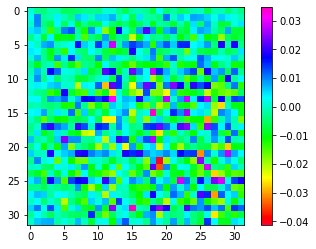

In [13]:
# 결과 이미지 생성

plt.imshow(generated_image[0, :, :, 0], cmap='gist_rainbow')
plt.colorbar()
plt.show()

### 3-3. 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인

#### 32 x 32 의 3차원 칼라이미지가 잘 생성되었다.

## STEP 4. 판별자 모델 구현하기

### 4-1. (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성

In [14]:
# 판별자 설계

def make_discriminator_model(alpha=0.2, dropout=0.4):  ## =======================================

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))  ## ===================================================
    model.add(layers.Dropout(dropout))  ## =======================================================

    # Second: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))  ## ===================================================
    model.add(layers.Dropout(dropout))  ## =======================================================

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [15]:
# 판별 모델을 discriminator라는 변수 이름으로 생성하고, 모델 세부 내용인 summary를 출력

discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 128)       9728      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)            

### 4-2. 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인

In [16]:
# 아까 생성했던 가짜 이미지를 판별자에 입력시키면 어떤 결과가 나올까

decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00222344]], dtype=float32)>

## STEP 5. 손실함수와 최적화 함수 구현하기

### 5-1. 생성자와 판별자의 손실함수(loss function)를 구현

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# generator_loss는 다음과 같이 구현

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
# discriminator_loss 구현

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 5-2. 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현

In [19]:
# discriminator accuracy 구현

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 5-3. 생성자와 판별자를 최적화하는 optimizer를 정의

In [20]:
# 최적화 함수(optimizer) 설정

generator_optimizer = tf.keras.optimizers.Adam(4e-4, beta_1=0.5)  ## ============================
discriminator_optimizer = tf.keras.optimizers.Adam(8e-4, beta_1=0.5)  ## ========================

In [21]:
# 고정된 seed 노이즈 (100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터)를 만듦

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## STEP 6. 훈련과정 상세 기능 구현하기

### 6-1. 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현

In [22]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

### 6-2. 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현

In [23]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] + 1)/2.0)
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples2/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

### 6-3. 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현

In [24]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history2/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

### 6-4. training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정

In [25]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints2'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 7. 학습 과정 진행하기

### 7-1. 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행

In [26]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [27]:
save_every = 5
EPOCHS = 100  ## ================================================================================

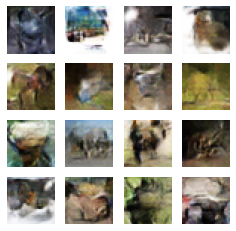

Time for training : 4491 sec


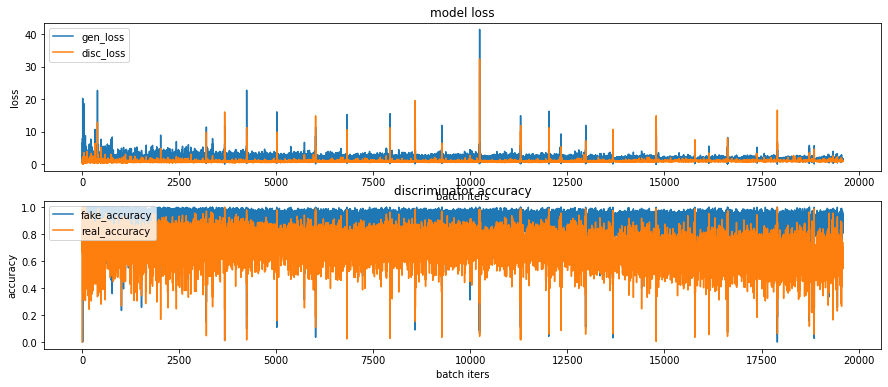

CPU times: user 1h 14min 24s, sys: 2min 36s, total: 1h 17min
Wall time: 1h 14min 52s


In [28]:
%%time
train(train_dataset, EPOCHS, save_every)

#### 훈련결과 생성된 이미지가 뚜렸하게 개선되었고 fake accuracy가 아주 미약하게나마 0.5를 향해 하향하고 있다.

### 7-2. 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현

In [29]:
# GIF 파일 만들기

anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples2/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

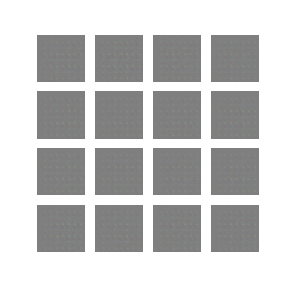

In [30]:
display.Image(filename=os.getenv('HOME')+"/aiffel/dcgan_newimage/cifar10/cifar10_dcgan2.gif")

#### gif를 통해 생성이미지 품질이 서서히 향상됨을 알 수 있다.

### 7-3. 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출

#### Github URL의 다음 directory 참조
1. 학습 과정을 담은 샘플 이미지 : generated_samples2
2. gif 파일 : gif_file2
3. 학습 진행 그래프 이미지 : training_history2

## STEP 8. GAN 훈련 과정 개선하기 (Optional)

### 8-1. STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석

#### 문제점
1. 생성됭 이미지가 어떤종류인지 분간하기 어렵다.
2. Fake accuracy 감소가 매우 미약하다.

#### 개선방안
참고 Link에 언급된 방법들 중 이해할 수 있는 방안들을 정리해 보았다.
1. 활성화 함수에 LeakyReLu를 사용 (기 사용)
2. Discriminator Optimizer로 SGD를 적용
3. Input에 Noise를 적용 (기 적용)
4. Train 및 test phase에 Dropout을 적용
5. Input data를 Normalize (기 적용)
6. GAN 대신 DCGAN을 사용 (기 사용)

### 8-2. 모델구조 또는 학습 과정을 개선한 내역과 그 결과를 함께 제출

#### 모델구조 또는 학습 과정을 개선한 내역
1. Discriminator optimizer로 ADAM 대신 SGD 적용 ==> 더 나빠져 다시 Adam 적용
2. Train 및 test phase에 Dropout을 적용
3. Epoch 수를 50에서 100으로 증가
4. 하이퍼 파라미터 조정

#### 학습 결과물은 Github URL의 다음 directory에 저장해 둠
(LMS Cloud Jupyter에서 작업했는데 많은 파일을 한개씩 다운받기 어려워 각 epoch당 1개씩만 저장했음)
1. 학습 과정을 담은 샘플 이미지 : generated_samples2
2. gif 파일 : gif_file2
3. 학습 진행 그래프 이미지 : training_history2

#### (참고) 아래 언급된 페이지들에서 개선을 위한 아이디어를 얻을 수 있을 것입니다.

How to Train a GAN? Tips and tricks to make GANs work

https://github.com/soumith/ganhacks

10 Lessons I Learned Training GANs for one Year

https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628

Tips for Training Stable Generative Adversarial Networks

https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/

Improved Techniques for Training GANs(paper)

https://papers.nips.cc/paper/6125-improved-techniques-for-training-gans.pdf

### 8-3. 개선방안 적용 전/후 비교

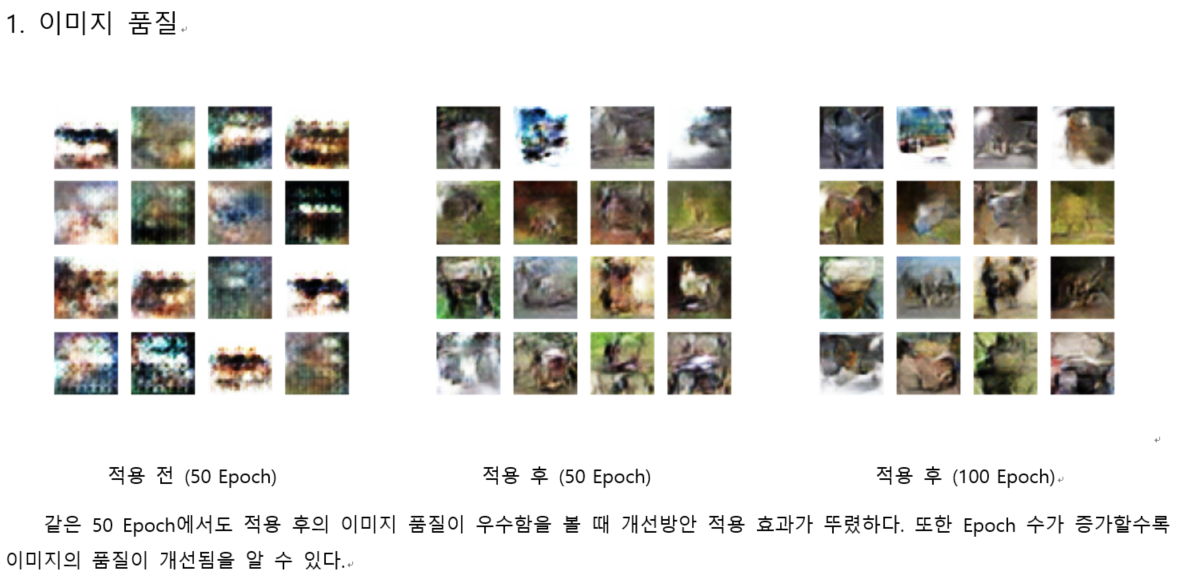

#### 2. Loss 및 Accuracy 변화상태
[적용 전]
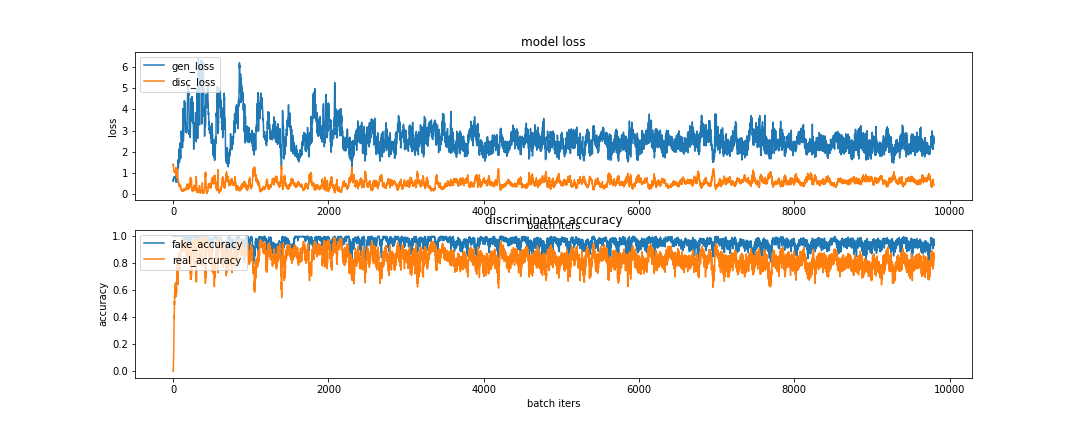


[적용 후]
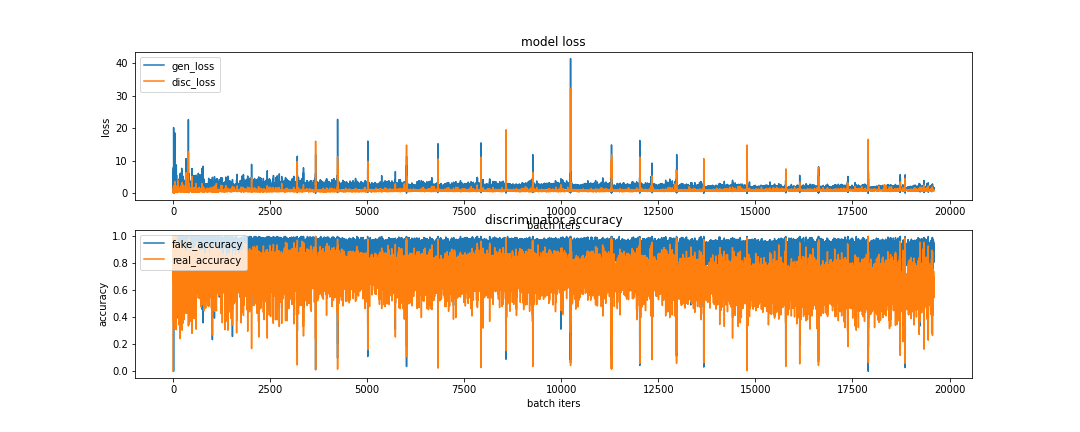

#### 개선방안 적용 후 Loss가 0에 근접하게 개선되었다. 특히 Generator loss가 눈에띄게 개선되었다. Fake Accuracy는 조금씩 하향하기는 하나 딱히 개선된 것으로 보지지 않는다. 반면 Real Accuracy는 많이 개선된것으로 보인다.

## 회고
### 이번 프로젝트에서 어려웠던 점

시간과의 싸움이었다. 100 epoch 한번 돌리는데 1시간 15분정도 걸린다. 이것저것 바꾸어가며 돌려보는데 한계가 있다. 어느정도 진전된 모습을 보이는 수준에서 개선작업을 멈췄다. 충분한 시간이 있다면 참고로 제시된 개선 아이디어 목록에 포함될 수 있을까? ㅎㅎ

### 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

1. Conv2DTranspose layer가 아직 LeakyReLu를 지원하지 않는다.
2. 각 function의 parameter들의 default값이 어느정도 성능은 내 줄것이라 생각했었는데 그렇지 않았다.
3. GIF file 만드는 방법을 알게되었다.

### 루브릭 평가 지표를 맞추기 위해 시도한 것들

1. Discriminator optimizer로 ADAM 대신 SGD 적용 ==> 더 나빠져 다시 Adam 적용
2. Train 및 test phase에 Dropout을 적용
3. Epoch 수를 50에서 100으로 증가
4. 하이퍼 파라미터 조정

### 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정

어느정도 달성했다고 생각됨. 부족하다면 좀더 많은 시간을 들여야 할것으로 생각된다.

### 자기 다짐

너무 목매고 하지 말자. (지쳐서 중도포기할지도....)